In [ ]:
!nvidia-smi

Fri Nov 10 05:15:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<h1>データの観察</h1>

32×32の、10クラス、各クラス6000枚の画像がある。
学習用は50,000、テスト用は10,000枚。~でそれぞれ10,000枚のバッチに分割。~
→大元はそうだったけど、torchvisionのデータセットから入れる場合は5万枚がただ揃ってるだけっぽい。

1画像につき、1024画素分の表がある各セルにはRGB三色分の数値が入っている。

データの取り出し方は以下を参考。
https://atmarkit.itmedia.co.jp/ait/articles/2006/10/news021.html

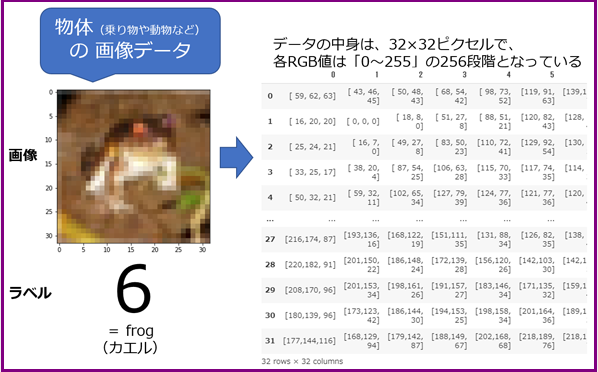

**ライブラリのダウンロード**

In [ ]:
!pip install torch torchvision


Data Loaderの使い方は以下。


https://qiita.com/tetsuro731/items/d64b9bbb8de6874b7064

In [ ]:
#CIFAR_10のデータのDL

import torch
import torchvision
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])



train_dataset = torchvision.datasets. CIFAR10(
    './cifar-10', train=True, download=True,
    transform=transform_train)


test_data = torchvision.datasets. CIFAR10(
    './cifar-10', train=False, download=True,
    transform=transform_test)

# train_dataをshuffleしてから分割

train_data, val_data = torch.utils.data.random_split(train_dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_data,  batch_size=1024, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 1024)

100%|██████████| 170498071/170498071 [00:03<00:00, 49817287.89it/s]


Extracting ./cifar-10/cifar-10-python.tar.gz to ./cifar-10
Files already downloaded and verified


In [ ]:
X_list, y_list = [], []
for i , (X, y) in enumerate(train_loader):
    print(i)
    X_list.append(X)
    y_list.append(y)
print('len:', len(X_list), len(y_list))

#学習データは5万枚なので、バッチサイズを1万にしたバッチ数が5になってる。



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
len: 40 40


In [ ]:
print(X.size())
print(y.size())

# 97×512 + 336 = 50,000 (最後のバッチだけ336個、残りバッチは512個のデータ)

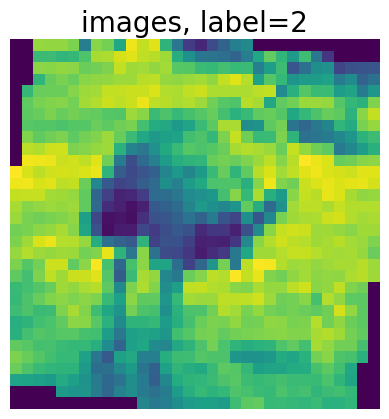

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(X[12][0])
ax.axis('off')
ax.set_title(f'images, label={y[12]}', fontsize=20)
plt.show()

#バッチ数は5つあるが、このリストの作り方では最後の40001～50000分しかリストに入っていないので、
#X[1～10000番目のどの写真?][R,G,Bのどれ？]
#y[1～10000番目のどのラベル?] という意味。

<h1>学習編</h1>

<h2>ライブラリのimport</h2>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

<h2>ネットワークの実装</h2>

In [ ]:
#シードの固定

torch.manual_seed(4931)

# インプットするデータは、32H×32W×3C(R,G,B)という次元なので、それに合うような入力はそれに合わせる。
# 最終結果は10クラスなので出力はこれに合わせる。

class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate = 0.2):
        super(SimpleCNN, self).__init__()
        # Input size: [batch_size, 3, 32, 32]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        # Current size: [batch_size, 32, 32, 32]
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Now apply a max pooling layer
        # Current size: [batch_size, 64, 32, 32]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Size after pooling: [batch_size, 64, 16, 16]
        # Apply another max pooling to reduce further
        # Size after second pooling: [batch_size, 64, 8, 8]
        self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(x)  # Apply pooling again to reduce to 8x8
        x = x.view(-1, 64 * 8 * 8)  # Flatten the tensor
        x = self.dropout(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the network
net = SimpleCNN()

# データ並列学習 ON
net = nn.DataParallel(net)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




<h2> 損失関数の定義 </h2>

In [ ]:
# 交差エントロピー
criterion = nn.CrossEntropyLoss()
# 確率的勾配降下法
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

<h1> 損失及び精度の可視化</h1>

<h2>学習</h2>

Epoch 1/500
Training loss: 1.769, Training accuracy: 37.590%
Validation loss: 1.739, Validation accuracy: 38.410%
Epoch 2/500
Training loss: 1.745, Training accuracy: 38.517%
Validation loss: 1.714, Validation accuracy: 39.600%
Epoch 3/500
Training loss: 1.719, Training accuracy: 39.322%
Validation loss: 1.693, Validation accuracy: 39.960%
Epoch 4/500
Training loss: 1.698, Training accuracy: 40.180%
Validation loss: 1.670, Validation accuracy: 41.710%
Epoch 5/500
Training loss: 1.674, Training accuracy: 41.000%
Validation loss: 1.646, Validation accuracy: 41.890%
Epoch 6/500
Training loss: 1.655, Training accuracy: 41.790%
Validation loss: 1.628, Validation accuracy: 42.770%
Epoch 7/500
Training loss: 1.630, Training accuracy: 42.485%
Validation loss: 1.607, Validation accuracy: 43.430%
Epoch 8/500
Training loss: 1.607, Training accuracy: 43.045%
Validation loss: 1.583, Validation accuracy: 44.340%
Epoch 9/500
Training loss: 1.579, Training accuracy: 43.992%
Validation loss: 1.561, Val

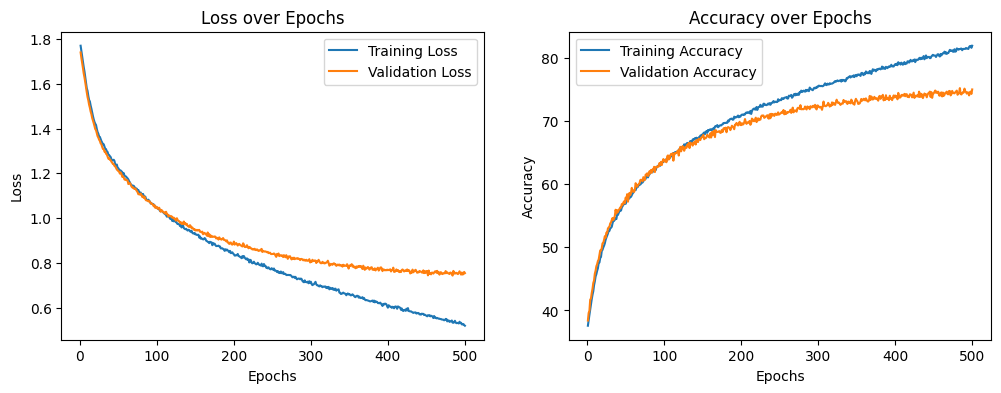

In [ ]:
num_epochs = 500
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    net.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for data in train_loader:                                     #enumerateでバッチに番号を振り、iでそれを引っ張ってくる。dataは一個ずつ引っ張り出してくるのではなく一気にバッチで学習する。
        inputs, labels = data                                     #画像データ,正解ラベルのペアになっているのを分解
        inputs, labels = inputs.to(device), labels.to(device)     #GPUに載せる
        optimizer.zero_grad()                                     #勾配を0に設定
        outputs = net(inputs)                                     #インスタンス化したモデルに、入力を加えることで主力を得る
        loss = criterion(outputs, labels)                         #指定した損失関数から損失を得る。この時点ではテンソルであることに注意。
        loss.backward()                                           #得た損失のテンソルから勾配を計算
        optimizer.step()                                          #得た勾配からパラメータを更新

        running_loss += loss.item()                               #各データの損失を、テンソルから普通の数字(フロート)に変換し、epochごとの損失を得るために足し合わせる。
        _, predicted = torch.max(outputs.data, 1)                 # 1:データの各クラス間 の最大値を、確率とその値を返す。
        total_train += labels.size(0)                             # バッチに含まれているデータの数を継ぎ足す。
        correct_train += (predicted == labels).sum().item()       # 正解した分のみを正答数に継ぎ足す。

    train_losses.append(running_loss / len(train_loader))         # epochごとに、平均損失リストに加えていく。
    train_accuracies.append(100 * correct_train / total_train)    # epochごとに正答率リストに加えていく。

    # Validation
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training loss: {train_losses[-1]:.3f}, Training accuracy: {train_accuracies[-1]:.3f}%')
    print(f'Validation loss: {val_losses[-1]:.3f}, Validation accuracy: {val_accuracies[-1]:.3f}%')

print('Finished Training')

# Plot the training and validation loss
plt.figure(figsize=(12, 4))                                              # 横12インチ、縦4インチのグラフを作成
plt.subplot(1, 2, 1)                                                     # 1行 2列にグラフを表示、最初に左からグラフをプロットする。
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()



In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/CA課題用/CA課題2'

model_save_path = save_path + '/simple_cnn_model.pth'

model_state_dict_path = save_path + '/simple_cnn_model_state_dict.pth'

torch.save(net.state_dict(), model_state_dict_path)



<h1> テスト編 </h1>

<h2>保存したモデルの呼び出し</h2>

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/CA課題用/CA課題2'

model_save_path = save_path + '/simple_cnn_model.pth'

model_state_dict_path = save_path + '/simple_cnn_model_state_dict.pth'


# Create the model architecture instance
net = SimpleCNN()

net = torch.nn.DataParallel(net)

# Load the state dictionary into the model
net.load_state_dict(torch.load(model_state_dict_path))

net = net.to('cuda')

net.eval()

DataParallel(
  (module): SimpleCNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=4096, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

<h2>TTAあり</h2>

<h3>Test Time Augmentationの実装</h3>

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import torch

# Define your transformations for TTA, e.g., random horizontal flips and random rotations
tta_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Function for TTA
def test_time_augmentation(model, device, data, num_augmentations=3):

    # Perform TTA
    outputs = []
    for _ in range(num_augmentations):
        # Apply transformations
        augmented_data = tta_transforms(data)
        augmented_data = augmented_data.to(device)

        # Get model output
        with torch.no_grad():
            output = model(augmented_data)
            outputs.append(output)


    # Combine predictions by averaging
    combined_output = torch.mean(torch.stack(outputs), dim=0)

    # Restore original model state

    return combined_output


<h3>TTA込みのInference</h3>

In [ ]:
from sklearn import metrics

test_loader = torch.utils.data.DataLoader(test_data)

label_list = []
pred_list = []

with torch.no_grad():
    for data, label in test_loader:
        data = data.squeeze(0).to('cuda')  # Remove batch dimension since we're using batch_size=1
        output = test_time_augmentation(net, 'cuda', data)
        _, pred = torch.max(output, 1)
        label_list.append(label.item())
        pred_list.append(pred.item())


print(metrics.classification_report(pred_list,label_list))

score = metrics.accuracy_score(label_list,pred_list)
print(score)



              precision    recall  f1-score   support

           0       0.26      0.32      0.29       802
           1       0.30      0.24      0.27      1247
           2       0.04      0.30      0.07       122
           3       0.00      0.00      0.00         3
           4       0.02      0.20      0.04        98
           5       0.00      0.00      0.00         0
           6       0.83      0.14      0.25      5728
           7       0.00      0.30      0.01        10
           8       0.04      0.21      0.07       191
           9       0.31      0.17      0.22      1799

    accuracy                           0.18     10000
   macro avg       0.18      0.19      0.12     10000
weighted avg       0.59      0.18      0.24     10000

0.1801


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h2>TTAなし</h2>

<h3>TTAなしのInference<h3>

In [ ]:
from sklearn import metrics
test_loader = torch.utils.data.DataLoader(test_data)

label_list = []
pred_list = []

with torch.no_grad():
    for data, label in test_loader:
        data = data.to('cuda')
        output = net(data)
        _, pred = torch.max(output, 1)

        label_list.extend(label.cpu().numpy().tolist())
        pred_list.extend(pred.cpu().numpy().tolist())


print(metrics.classification_report(pred_list,label_list))

score = metrics.accuracy_score(label_list,pred_list)
print(score)

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1080
           1       0.88      0.81      0.84      1089
           2       0.63      0.71      0.67       890
           3       0.57      0.59      0.58       974
           4       0.73      0.73      0.73      1011
           5       0.68      0.66      0.67      1027
           6       0.82      0.81      0.82      1019
           7       0.81      0.84      0.83       962
           8       0.85      0.84      0.85      1019
           9       0.79      0.85      0.82       929

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

0.7591
